In [1]:
import pandas as pd
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_folder = '/kaggle/input/airbus-ship-detection/train_v2'

### let's look at images

In [3]:
img_list = []

for f in os.listdir(train_folder):
    img_list.append(os.path.join(train_folder, f))

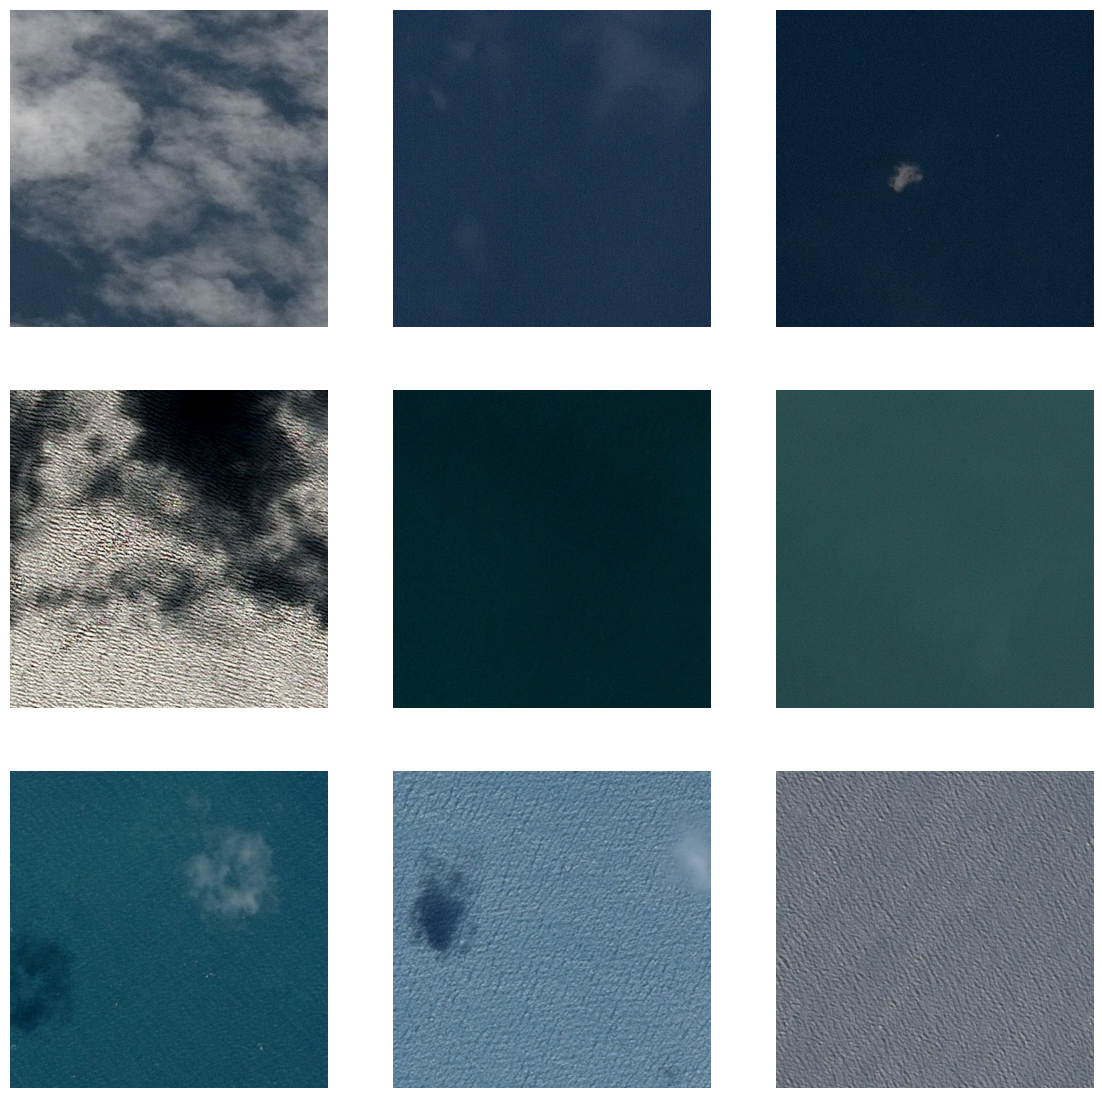

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(14, 14))

for i, ax in enumerate(axs.flat):
    N = np.random.randint(len(img_list))
    img = imageio.imread(img_list[N])
    ax.axis('off')
    ax.imshow(img)

plt.show()

In [5]:
img.shape

(768, 768, 3)

### let's look at annotations

In [6]:
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

In [7]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [8]:
df.shape

(231723, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [10]:
df.ImageId.unique().shape

(192556,)

---
**81723 / 231723** records have some annotated pixels.\
So, **231723 - 81723 = 150000** records (and so images) without any ships.\
Total number of unique records (and so images) = **192556**\
So, **192556 - 150000 = 42556** images contain some ships.

Seems like it would be more effective training if we drop images without ships. It would be still enough data to train on. taking that "ship / background" ratio is very low, we have enough background anyway.

---

In [11]:
df = df.dropna().copy()

### num of pixels for one ship

In [12]:
df['OneShipPixels'] = df['EncodedPixels'].apply(lambda pixs: sum(int(x) for x in pixs.strip().split(' ')[1::2]))

In [13]:
df['OneShipPixels']

2         3388
3          177
4          148
5          480
6            7
          ... 
231694     401
231709     902
231712      30
231713     128
231714    4476
Name: OneShipPixels, Length: 81723, dtype: int64

In [14]:
df['PercentageOneShipPixels'] = 100*df['OneShipPixels'] / (768*768)

### num of ship pixels per image

In [15]:
df['ShipPixelsPerImage'] = df.groupby('ImageId')['OneShipPixels'].transform('sum')

In [16]:
df['ShipPixelsPerImage'].sort_values()

86511        10
122897       10
57273        10
97340        10
92336        10
          ...  
185551    76720
185547    76720
185552    76720
185548    76720
185546    76720
Name: ShipPixelsPerImage, Length: 81723, dtype: int64

In [17]:
df['PercentageShipPixelsPerImage'] = 100*df['ShipPixelsPerImage'] / (768*768)

In [18]:
df.sort_values(['PercentageShipPixelsPerImage'])

,ImageId,EncodedPixels,OneShipPixels,PercentageOneShipPixels,ShipPixelsPerImage,PercentageShipPixelsPerImage
86511,5f83317ca.jpg,514287 2 515055 2 515823 3 516591 3,10,0.001695,10,0.001695
122897,87a819da8.jpg,167556 2 168324 3 169091 4 169861 1,10,0.001695,10,0.001695
57273,3fa93dcf7.jpg,49613 2 50381 2 51148 3 51916 3,10,0.001695,10,0.001695
97340,6b583e9c9.jpg,246221 2 246989 2 247756 3 248524 3,10,0.001695,10,0.001695
92336,65d635a6d.jpg,49869 2 50637 2 51404 3 52172 3,10,0.001695,10,0.001695
...,...,...,...,...,...,...
185551,ccfb18b6c.jpg,346023 1 346790 3 347557 5 348324 7 349092 9 3...,16392,2.779134,76720,13.007270
185547,ccfb18b6c.jpg,235900 1 236667 3 237434 5 238201 8 238969 9 2...,10542,1.787313,76720,13.007270
185552,ccfb18b6c.jpg,268215 1 268982 3 269749 5 270516 8 271284 9 2...,9912,1.680501,76720,13.007270
185548,ccfb18b6c.jpg,262162 1 262929 3 263696 5 264463 8 265230 10 ...,14622,2.479045,76720,13.007270


### let's look at all statistics

In [19]:
df.describe()

,OneShipPixels,PercentageOneShipPixels,ShipPixelsPerImage,PercentageShipPixelsPerImage
count,81723.000000,81723.000000,81723.000000,81723.000000
mean,1567.402849,0.265741,3798.857311,0.644066
std,2842.081203,0.481852,5023.916961,0.851765
min,2.000000,0.000339,10.000000,0.001695
25%,111.000000,0.018819,412.000000,0.069851
50%,408.000000,0.069173,1857.000000,0.314840
75%,1550.000000,0.262790,5321.000000,0.902134
max,25904.000000,4.391819,76720.000000,13.007270


---
#### Now we see how much our dataset is unbalanced: in average only 0.64% of image is object. That's why we need consider to use Dice/IOU/Focal Loss functions instead of BCE, for example.

<Axes: >

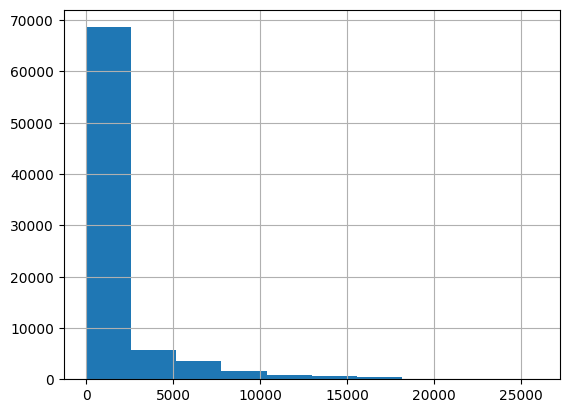

In [20]:
df['OneShipPixels'].hist()

<Axes: >

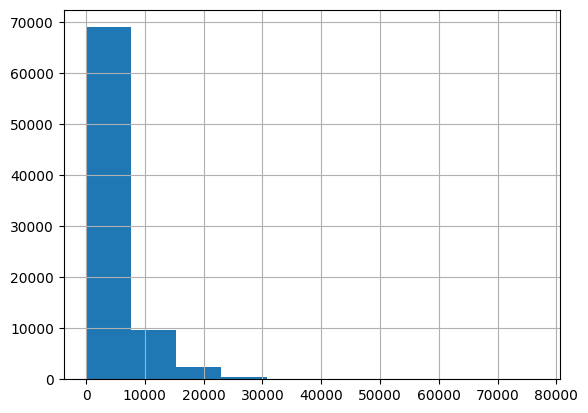

In [21]:
df['ShipPixelsPerImage'].hist()